In [1]:
import os
import sys
sys.path.append('D:\\Users\\Hegxiten\\workspace\\Rutgers_Railway_security_research\\OOD_Train')

from datetime import datetime, timedelta
import numpy as np
import random
from infrastructure import Track, Block, BigBlock
from signaling import AutoSignal, HomeSignal, AutoPoint, ControlPoint
from system import System
from train import Train
import networkx as nx


In [2]:
sim_init_time = datetime.strptime('2018-01-10 10:00:00', "%Y-%m-%d %H:%M:%S")
sim_term_time = datetime.strptime('2018-01-10 15:30:00', "%Y-%m-%d %H:%M:%S")
sp_container = [random.uniform(0.01, 0.02) for i in range(20)]
acc_container = [random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
dcc_container = [random.uniform(2.78e-05*0.85, 2.78e-05*1.15) for i in range(20)]
headway = 200 * random.random() + 400
sys = System(sim_init_time, sp_container, acc_container, dcc_container,
             dos_period=['2018-01-10 11:30:00', '2018-01-10 12:30:00'],  
             headway=headway, 
             tracks=[1,1,1,4,1,1,3,1,1,1], 
             dos_pos=-1)
k166 = Train(idx=sys.train_num, 
                  rank=sys.train_num, 
                  system=sys, 
                  init_time=sys.sys_time, 
                  init_segment=((sys.signal_points[6],0),(sys.signal_points[5],1)),
                  max_sp=sys.sp_container[sys.train_num % len(sys.sp_container)], 
                  max_acc=sys.acc_container[sys.train_num % len(sys.acc_container)], 
                  max_dcc=sys.dcc_container[sys.train_num % len(sys.dcc_container)])

In [3]:
for t in sys.tracks:
    print(t.train)

for b in sys.curr_routing_paths:
    print(len(b))
    for i in b:
        print('\t',i)

[]
[]
[]
[]
[]
[]
[train index 0, current segment/direction ((ControlPoint6, 0), (AutoPoint5, 1))]
[]
[]
[]
[]
[]


In [6]:
for n in range(3600):
#     print('k165: curr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tacc: {}'.format("%.2f" % round(k165.curr_MP,2), \
#                                                                    "%.2f" % round(k165.curr_speed*3600,2), \
#                                                                    "%.2f" % round(k165.curr_target_spd_abs*3600,2), \
#                                                                    "%.10f" % round(k165.curr_acc,10)))
    print('k166: curr_MP: {}, \tcurr_spd: {}, \ttgt_spd: {},\tbrk_dis: {}, \tacc: {},'.format(\
                                                                    "%.2f" % round(k166.curr_MP,2), \
                                                                   "%.2f" % round(k166.curr_speed*3600,2), \
                                                                   "%.2f" % round(k166.curr_target_spd_abs*3600,2), \
                                                                   "%.2f" % round(k166.curr_brake_distance_abs,2), \
                                                                   "%.10f" % round(k166.curr_acc,10)))
    k166.update_acc()
#     k165.update_acc()
    sys.sys_time+=1

k166: curr_MP: 25.00, 	curr_spd: 0.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.11, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.22, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.32, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.43, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.54, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.65, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.76, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.86, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -0.97, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 25.00, 	curr_spd: -1.08, 	tgt_spd: 65.00,	brk_dis: 0.00,

k166: curr_MP: 24.87, 	curr_spd: -10.05, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.87, 	curr_spd: -10.16, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.86, 	curr_spd: -10.27, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.86, 	curr_spd: -10.37, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.86, 	curr_spd: -10.48, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.86, 	curr_spd: -10.59, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.85, 	curr_spd: -10.70, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.85, 	curr_spd: -10.81, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.85, 	curr_spd: -10.91, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.84, 	curr_spd: -11.02, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.84, 	curr_spd: -11.13, 	tgt_spd: 65.00,	br

k166: curr_MP: 24.34, 	curr_spd: -22.59, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.34, 	curr_spd: -22.69, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.33, 	curr_spd: -22.80, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.33, 	curr_spd: -22.91, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.32, 	curr_spd: -23.02, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.31, 	curr_spd: -23.13, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.31, 	curr_spd: -23.23, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.30, 	curr_spd: -23.34, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.29, 	curr_spd: -23.45, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.29, 	curr_spd: -23.56, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 24.28, 	curr_spd: -23.67, 	tgt_spd: 65.00,	br

k166: curr_MP: 23.59, 	curr_spd: -33.07, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.59, 	curr_spd: -33.18, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.58, 	curr_spd: -33.28, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.57, 	curr_spd: -33.39, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.56, 	curr_spd: -33.50, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.55, 	curr_spd: -33.61, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.54, 	curr_spd: -33.72, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.53, 	curr_spd: -33.82, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.52, 	curr_spd: -33.93, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.51, 	curr_spd: -34.04, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 23.50, 	curr_spd: -34.15, 	tgt_spd: 65.00,	br

k166: curr_MP: 22.43, 	curr_spd: -44.74, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.42, 	curr_spd: -44.85, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.40, 	curr_spd: -44.95, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.39, 	curr_spd: -45.06, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.38, 	curr_spd: -45.17, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.37, 	curr_spd: -45.28, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.35, 	curr_spd: -45.39, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.34, 	curr_spd: -45.49, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.33, 	curr_spd: -45.60, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.31, 	curr_spd: -45.71, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 22.30, 	curr_spd: -45.82, 	tgt_spd: 65.00,	br

k166: curr_MP: 20.97, 	curr_spd: -55.98, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.96, 	curr_spd: -56.08, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.94, 	curr_spd: -56.19, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.93, 	curr_spd: -56.30, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.91, 	curr_spd: -56.41, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.89, 	curr_spd: -56.52, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.88, 	curr_spd: -56.63, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.86, 	curr_spd: -56.73, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.85, 	curr_spd: -56.84, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.83, 	curr_spd: -56.95, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: -0.0000300176,
k166: curr_MP: 20.82, 	curr_spd: -57.06, 	tgt_spd: 65.00,	br

k166: curr_MP: 19.31, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.29, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.27, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.25, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.24, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.22, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.20, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.18, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.16, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.15, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 19.13, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.0

k166: curr_MP: 17.36, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.34, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.32, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.30, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.29, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.27, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.25, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.23, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.21, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.20, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 17.18, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.0

k166: curr_MP: 15.41, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.39, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.37, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.35, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.34, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.32, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.30, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.28, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.26, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.25, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 15.23, 	curr_spd: -65.00, 	tgt_spd: 65.00,	brk_dis: 0.0

k166: curr_MP: 13.67, 	curr_spd: -56.00, 	tgt_spd: 40.00,	brk_dis: 1.87, 	acc: 0.0000316619,
k166: curr_MP: 13.65, 	curr_spd: -55.88, 	tgt_spd: 40.00,	brk_dis: 1.86, 	acc: 0.0000316619,
k166: curr_MP: 13.63, 	curr_spd: -55.77, 	tgt_spd: 40.00,	brk_dis: 1.84, 	acc: 0.0000316619,
k166: curr_MP: 13.62, 	curr_spd: -55.65, 	tgt_spd: 40.00,	brk_dis: 1.82, 	acc: 0.0000316619,
k166: curr_MP: 13.60, 	curr_spd: -55.54, 	tgt_spd: 40.00,	brk_dis: 1.81, 	acc: 0.0000316619,
k166: curr_MP: 13.59, 	curr_spd: -55.43, 	tgt_spd: 40.00,	brk_dis: 1.79, 	acc: 0.0000316619,
k166: curr_MP: 13.57, 	curr_spd: -55.31, 	tgt_spd: 40.00,	brk_dis: 1.78, 	acc: 0.0000316619,
k166: curr_MP: 13.56, 	curr_spd: -55.20, 	tgt_spd: 40.00,	brk_dis: 1.76, 	acc: 0.0000316619,
k166: curr_MP: 13.54, 	curr_spd: -55.08, 	tgt_spd: 40.00,	brk_dis: 1.75, 	acc: 0.0000316619,
k166: curr_MP: 13.53, 	curr_spd: -54.97, 	tgt_spd: 40.00,	brk_dis: 1.73, 	acc: 0.0000316619,
k166: curr_MP: 13.51, 	curr_spd: -54.86, 	tgt_spd: 40.00,	brk_dis: 1.7

k166: curr_MP: 12.01, 	curr_spd: -42.20, 	tgt_spd: 40.00,	brk_dis: 0.22, 	acc: 0.0000316619,
k166: curr_MP: 12.00, 	curr_spd: -42.09, 	tgt_spd: 40.00,	brk_dis: 0.21, 	acc: 0.0000316619,
k166: curr_MP: 11.99, 	curr_spd: -41.98, 	tgt_spd: 40.00,	brk_dis: 0.20, 	acc: 0.0000316619,
k166: curr_MP: 11.98, 	curr_spd: -41.86, 	tgt_spd: 40.00,	brk_dis: 0.19, 	acc: 0.0000316619,
k166: curr_MP: 11.97, 	curr_spd: -41.75, 	tgt_spd: 40.00,	brk_dis: 0.17, 	acc: 0.0000316619,
k166: curr_MP: 11.96, 	curr_spd: -41.63, 	tgt_spd: 40.00,	brk_dis: 0.16, 	acc: 0.0000316619,
k166: curr_MP: 11.95, 	curr_spd: -41.52, 	tgt_spd: 40.00,	brk_dis: 0.15, 	acc: 0.0000316619,
k166: curr_MP: 11.93, 	curr_spd: -41.41, 	tgt_spd: 40.00,	brk_dis: 0.14, 	acc: 0.0000316619,
k166: curr_MP: 11.92, 	curr_spd: -41.29, 	tgt_spd: 40.00,	brk_dis: 0.13, 	acc: 0.0000316619,
k166: curr_MP: 11.91, 	curr_spd: -41.18, 	tgt_spd: 40.00,	brk_dis: 0.12, 	acc: 0.0000316619,
k166: curr_MP: 11.90, 	curr_spd: -41.06, 	tgt_spd: 40.00,	brk_dis: 0.1

k166: curr_MP: 10.79, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.78, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.76, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.75, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.74, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.73, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.72, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.71, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.70, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.69, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 10.68, 	curr_spd: -40.00, 	tgt_spd: 40.00,	brk_dis: 0.0

k166: curr_MP: 9.57, 	curr_spd: -35.33, 	tgt_spd: 20.00,	brk_dis: 1.03, 	acc: 0.0000316619,
k166: curr_MP: 9.56, 	curr_spd: -35.21, 	tgt_spd: 20.00,	brk_dis: 1.02, 	acc: 0.0000316619,
k166: curr_MP: 9.55, 	curr_spd: -35.10, 	tgt_spd: 20.00,	brk_dis: 1.01, 	acc: 0.0000316619,
k166: curr_MP: 9.54, 	curr_spd: -34.98, 	tgt_spd: 20.00,	brk_dis: 1.00, 	acc: 0.0000316619,
k166: curr_MP: 9.53, 	curr_spd: -34.87, 	tgt_spd: 20.00,	brk_dis: 0.99, 	acc: 0.0000316619,
k166: curr_MP: 9.52, 	curr_spd: -34.76, 	tgt_spd: 20.00,	brk_dis: 0.98, 	acc: 0.0000316619,
k166: curr_MP: 9.51, 	curr_spd: -34.64, 	tgt_spd: 20.00,	brk_dis: 0.97, 	acc: 0.0000316619,
k166: curr_MP: 9.50, 	curr_spd: -34.53, 	tgt_spd: 20.00,	brk_dis: 0.97, 	acc: 0.0000316619,
k166: curr_MP: 9.49, 	curr_spd: -34.41, 	tgt_spd: 20.00,	brk_dis: 0.96, 	acc: 0.0000316619,
k166: curr_MP: 9.48, 	curr_spd: -34.30, 	tgt_spd: 20.00,	brk_dis: 0.95, 	acc: 0.0000316619,
k166: curr_MP: 9.47, 	curr_spd: -34.19, 	tgt_spd: 20.00,	brk_dis: 0.94, 	acc: 0.

k166: curr_MP: 8.50, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.49, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.49, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.48, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.48, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.47, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.47, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.46, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.45, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.45, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 8.44, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.

k166: curr_MP: 7.79, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.78, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.78, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.77, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.77, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.76, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.75, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.75, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.74, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.74, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 7.73, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.

k166: curr_MP: 6.96, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.95, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.95, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.94, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.94, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.93, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.93, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.92, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.92, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.91, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.90, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.

k166: curr_MP: 6.10, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.09, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.09, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.08, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.08, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.07, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.07, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.06, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.05, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.05, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 6.04, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.

k166: curr_MP: 5.14, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.14, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.13, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.13, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.12, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.12, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.11, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.10, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.10, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.09, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 5.09, 	curr_spd: -20.00, 	tgt_spd: 20.00,	brk_dis: 0.00, 	acc: 0.

k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 

k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 

k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 	curr_spd: 0.00, 	tgt_spd: 0.00,	brk_dis: 0.00, 	acc: 0.0000000000,
k166: curr_MP: 4.51, 

In [5]:
sys.signal_points[4].open_route((1,0))
# [n.close_route() for n in sys.control_points]
for b in sys.bigblocks:
    print(b, b.routing)

route (1, 0) of ControlPoint4 is opened
BigBlock MP: 0.0 to MP: 15.0 idx: 0 ((ControlPoint3, 0), (ControlPoint0, 1))
BigBlock MP: 15.0 to MP: 20.0 idx: 0 ((ControlPoint4, 0), (ControlPoint3, 1))
BigBlock MP: 15.0 to MP: 20.0 idx: 1 None
BigBlock MP: 20.0 to MP: 30.0 idx: 0 ((ControlPoint6, 0), (ControlPoint4, 1))
BigBlock MP: 30.0 to MP: 35.0 idx: 0 None
BigBlock MP: 30.0 to MP: 35.0 idx: 1 None
BigBlock MP: 35.0 to MP: 50.0 idx: 0 None


In [44]:
for i in range(len(sys.signal_points)):
    print(i, sys.signal_points[i].signal_by_port[1].aspect)

0 Aspect: r, 	 route None, target speed 0.0 mph
1 Aspect: y, 	 route (1, 0), target speed 20.0 mph
2 Aspect: yy, 	 route (1, 0), target speed 40.0 mph
3 Aspect: r, 	 route None, target speed 0.0 mph
4 Aspect: r, 	 route None, target speed 0.0 mph
5 Aspect: y, 	 route (1, 0), target speed 20.0 mph
6 Aspect: r, 	 route None, target speed 0.0 mph
7 Aspect: r, 	 route None, target speed 0.0 mph
8 Aspect: r, 	 route None, target speed 0.0 mph
9 Aspect: r, 	 route None, target speed 0.0 mph
10 Aspect: r, 	 route None, target speed 0.0 mph


In [57]:
k166.curr_brake_distance_abs/30*1610

412.8484927972387

In [26]:
[print(b.routing) for b in sys.bigblocks]

((ControlPoint0, 1), (ControlPoint3, 0))
((ControlPoint4, 0), (ControlPoint3, 1))
((ControlPoint3, 3), (ControlPoint4, 2))
((ControlPoint6, 0), (ControlPoint4, 1))
None
None
None


[None, None, None, None, None, None, None]

No handles with labels found to put in legend.


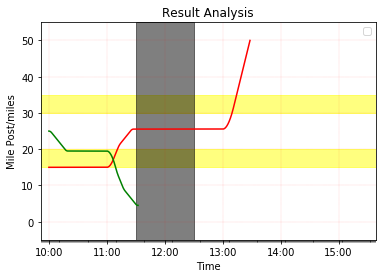

In [30]:
from infrastructure import Track, Block, BigBlock
from system import System
from train import Train
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
def string_diagram(sys, start_time, end_time):
    '''To draw the string diagram based on the schedule dictionary for all the trains. 
    '''
    colors = ['red','green','blue','black','orange','cyan','magenta']
    color_num = len(colors)
    x, y = [], []
    for i in range(len(sys.trains)):
        x.append([])
        y.append([])
        for j in range(len(sys.trains[i].time_pos_list)):
            x[i].append(datetime.fromtimestamp(sys.trains[i].time_pos_list[j][0]))
            y[i].append(sys.trains[i].time_pos_list[j][1])
            # x[i].append(sys.trains[i].time_pos_list[j][0])
            # y[i].append(sys.trains[i].time_pos_list[j][1])

    y = [i for _,i in sorted(zip([i[0] for i in x], y))]
    x = sorted(x, key = lambda x: x[0])
    assert len(x) == len(y)
    train_idx = list(range(len(x)))
    t_color = [colors[x.index(i)%color_num] for i in x]
    min_t, max_t = min([i[0] for i in x]), max([i[-1] for i in x])

    #plt.ion()
    plt.title('Result Analysis')
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator()
    seconds = mdates.SecondLocator()
    dateFmt = mdates.DateFormatter("%H:%M")
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_minor_locator(minutes)
    plt.gca().xaxis.set_major_formatter(dateFmt)
    plt.xticks(rotation=90)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.1")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Mile Post/miles')
    start_time = int(start_time.timestamp())
    end_time = int(end_time.timestamp())
    plt.axis([(datetime.fromtimestamp(start_time - 500)), \
            (datetime.fromtimestamp(end_time + 500)), -5 , 55])
    #===============================================================================
    # time_length = end_time - start_time
    # step_size = 10
    # for start in range(1,time_length + 1, step_size):
    #     plt.axis([(datetime.fromtimestamp(start_time - 500)), \
    #         (datetime.fromtimestamp(end_time + 500)), -5 , 55])
         
    #     for n in range(len(x)-1):
    #         new_x_y = [[mdates.date2num(datetime.fromtimestamp(i)), j] for i, j in zip(x[n], y[n]) if i < start_time + start and i > start_time + start - 1 - step_size]
    #         new_x = []
    #         new_y = []
    #         for i , j in new_x_y:
    #             new_x.append(i)
    #             new_y.append(j)
    #         if(len(new_x) == 0):
    #             continue
    #         plt.plot(new_x, new_y, color=t_color[n])
    #         # print('==============')
    #         # print('Length of new_x: {}'.format(len(new_x)))
    #         # print('Length of new_y: {}'.format(len(new_y)))
    #     plt.pause(0.00001)
    #===============================================================================
    
    for n in range(len(x)):
        #assert len(x[n]) == len(y[n]) == t_color[n]
        plt.plot([mdates.date2num(i) for i in x[n]], y[n], color=t_color[n])
    plt.gca().axhspan(15,20,color='yellow',alpha=0.5)
    plt.gca().axhspan(30,35,color='yellow',alpha=0.5)
    plt.gca().axvspan((datetime.fromtimestamp(start_time + 90 * 60)),(datetime.fromtimestamp(start_time + 150 * 60)),color='black',alpha=0.5)
    plt.show()
    #plt.ioff()
string_diagram(sys, sim_init_time, sim_term_time)

In [9]:
((k166.curr_speed*3600)**2-k166.curr_target_spd_abs*3600**2)/7200

-19.415034511653136

In [15]:
for n in range(3600):
    print('k165: curr_MP: {}, curr_spd: {}, curr_tgt_spd'.format(k165.curr_MP, k165.curr_speed, k165.curr_target_spd_abs))
    print('k166: curr_MP: {}, curr_spd: {}, curr_tgt_spd'.format(k166.curr_MP, k166.curr_speed, k166.curr_target_spd_abs))
    k166.update_acc()
    k165.update_acc()
    sys.sys_time+=1

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.54431809864747

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107, curr_spd: 0, curr_tgt_spd
k165: curr_MP: 25.544318098647476, curr_spd: 0, curr_tgt_spd
k166: curr_MP: 4.498811346044107

In [17]:
v2=k166.curr_target_spd_abs
v1=k166.curr_speed
a = k166.curr_acc
(v2**2-v1**2)/(2*a)

-3.556605286883763

In [26]:
(v1**2-v2**2)/(2*a)

3.556605286883763